In [1]:
import os
import json
import requests
import time
import sys
import shutil

import glob
import pickle
import torch
import safetensors.torch
import PIL
import numpy as np
import matplotlib.pyplot as plt





In [2]:


def ensure_folder_exists(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)  # 自動建立資料夾



In [3]:
prefixs = [ "LoRA_Trigger", "LoRA_noTrigger", "noLoRA_Trigger", "noLoRA_noTrigger"]


In [ ]:
def rename_files():
    base_path = "..\\data\\input"
    for p in prefixs:
        folder_path = os.path.join(base_path, p)
        ensure_folder_exists(folder_path)
        counter = 0
        for file_name in os.listdir(folder_path):
            print(file_name)
            src = os.path.join(folder_path, file_name)
            dst = os.path.join(folder_path, p + "_" + str(counter) + ".png")
            os.rename(src, dst)
            counter += 1


In [ ]:
rename_files()

In [4]:
# read api from json file
api = {}
with open("anaysis with LoRA api.json", "r") as f:
    api = f.read()
api = json.loads(api)

trigger_prompt = "zzMimikyu, solo, pokemon (creature), no humans, animal focus, mimikyu, "
object_prompt = "A fire red rat"

In [5]:
class Config:
    def __init__(self, model, LoRA, input_image, trigger_prompt, object_prompt, file_prefix, total_steps, current_step):
        self.model = model
        self.LoRA = LoRA
        self.input_image = input_image
        self.trigger_prompt = trigger_prompt
        self.object_prompt = object_prompt
        self.short_object_prompt = object_prompt.split(",")[0].strip()[0:20]
        self.file_prefix = file_prefix
        self.total_steps = total_steps
        self.current_step = current_step

    def add_step(self):
        self.current_step += 1

    def set_input_image(self, input_image):
        self.input_image = input_image

config = Config(
    model="sd_xl_base_1.0.safetensors",
    LoRA="Mimikyu_Pokemon_PDXL.safetensors",
    input_image="input_image.png",
    trigger_prompt=trigger_prompt,
    object_prompt=object_prompt,
    file_prefix=prefixs,
    total_steps=20,
    current_step=0
)

In [6]:
print(config.short_object_prompt)

A fire red rat


In [7]:
import json
import requests
def send_request(api):
    # 3. 設定 API 的 URL 與 headers
    url = 'http://127.0.0.1:8188/prompt'
    headers = {'Content-Type': 'application/json'}

    # 4. 發送 POST request 並傳送修改後的 JSON 資料
    response = requests.post(url, headers=headers, data=json.dumps(api))

    # 5. 輸出回應結果
    print(response.status_code)
    print(response.json())

In [8]:


def modify_api(api, config, counter = 0):
    api["prompt"]["3"]["inputs"]["ckpt_name"] = config.model
    api["prompt"]["2"]["inputs"]["lora_name"] = config.LoRA
    api["prompt"]["7"]["inputs"]["image"] = config.input_image
    api["prompt"]["4"]["inputs"]["text"] = config.trigger_prompt + config.object_prompt
    api["prompt"]["11"]["inputs"]["filename_prefix"] = f"{config.file_prefix}/{config.short_object_prompt}/{config.input_image}/{config.current_step}"
    api["prompt"]["15"]["inputs"]["filename_prefix"] = f"{config.file_prefix}/{config.short_object_prompt}/{config.input_image}/{config.current_step}@{counter}@"
    api["prompt"]["10"]["inputs"]["steps"] = config.total_steps
    api["prompt"]["10"]["inputs"]["denoise"] =  1-config.current_step/ config.total_steps
    api["prompt"]["1"]["inputs"]["start_at_step"] = config.current_step
    api["prompt"]["1"]["inputs"]["end_at_step"] = config.current_step + 1
    return api

In [ ]:
import shutil
output_folder = "..\\..\\..\\myComfyUI\\output\\lab\\hspace"
for filename in os.listdir(output_folder):
    file_path = os.path.join(output_folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print(f'Failed to delete {file_path}. Reason: {e}')

In [ ]:
import shutil


generate_counter = 1

for prefix in prefixs:
    config.file_prefix = prefix
    # object_prompt = "a cute rat"
    # config.object_prompt = object_prompt
    for input_image in os.listdir(f"..\\..\\..\\myComfyUI\\input"):
        if prefix not in input_image:
            continue
        print(f"{prefix} {object_prompt} {input_image}")
        config.set_input_image(input_image)
        config.current_step = 0
        for i in range(20-1):
            config.current_step = i
            api = modify_api(api, config, generate_counter)
            generate_counter += 1
            send_request(api)
            print(f"{prefix} {object_prompt} {i} done")

In [9]:
hspace_folder = "..\\..\\..\\myComfyUI\\output\\lab\\hspace"
data_folder = "..\\data"


In [ ]:

for prefix in os.listdir(data_folder):
    for prompt in os.listdir(os.path.join(data_folder, prefix)):
        for image_name in os.listdir(os.path.join(data_folder, prefix, prompt)):
            for file_name in os.listdir(os.path.join(data_folder, prefix, prompt, image_name)):
                
                if '@' in file_name:
                    index = file_name.split('@')[1]
                    print(index)
                    hspace_file = os.path.join(hspace_folder, index+".pkl")
                    destination = os.path.join(data_folder, prefix, prompt, image_name)
                    # if hspace file exist
                    if os.path.exists(hspace_file):
                        shutil.move(hspace_file, destination)
                    else:
                        print(f"{hspace_file} not exist")




        


In [ ]:
class read_file():
    def __init__(self, file_path):
        pass

    def load_hspace_file(filepath):
        """讀取 .pkl 檔案，並將 numpy.ndarray 轉換為 numpy array"""
        with open(filepath, 'rb') as f:
            arr = pickle.load(f)
        return arr

    def load_latent_file(filepath):
        """利用 safetensors.torch 讀取 .latent 檔案，並取出 'latent_tensor'"""
        sd = safetensors.torch.load_file(filepath)
        return sd['latent_tensor'].numpy()

    def load_image_file(filepath):
        """讀取圖片檔案，並轉換為 numpy array"""
        img = PIL.Image.open(filepath)
        return np.array(img)


In [ ]:
experiment_data = {}
for prefix in os.listdir(data_folder):
    experiment_data[prefix] = {}
    for prompt in os.listdir(os.path.join(data_folder, prefix)):
        experiment_data[prefix][prompt] = {}
        for image_name in os.listdir(os.path.join(data_folder, prefix, prompt)):
            experiment_data[prefix][prompt][image_name] = {}
            experiment_data[prefix][prompt][image_name]["hspace"] = []
            experiment_data[prefix][prompt][image_name]["image"] = []
            experiment_data[prefix][prompt][image_name]["latent"] = []

            start_index = 9999999999
            for file_name in os.listdir(os.path.join(data_folder, prefix, prompt, image_name)):
                if '@' in file_name:
                    print(file_name)
                    index = int(file_name.split('@')[1])
                    start_index = min(start_index, index)
            
            
            for i in range(20-1):
                hspace_file = os.path.join(data_folder, prefix, prompt, image_name, f"{start_index+i}.pkl")
                image_file = os.path.join(data_folder, prefix, prompt, image_name, f"{i}@{start_index+i}@_00001_.png")
                latent_file = os.path.join(data_folder, prefix, prompt, image_name, f"{i}_00001_.latent")

                if os.path.exists(hspace_file) and os.path.exists(image_file) and os.path.exists(latent_file):
                    experiment_data[prefix][prompt][image_name]["hspace"].append(read_file.load_hspace_file(hspace_file))
                    experiment_data[prefix][prompt][image_name]["image"].append(read_file.load_image_file(image_file))
                    experiment_data[prefix][prompt][image_name]["latent"].append(read_file.load_latent_file(latent_file))
                else:
                    if not os.path.exists(hspace_file):
                        print(f"{hspace_file} not exist")
                    if not os.path.exists(image_file):
                        print(f"{image_file} not exist")
                    if not os.path.exists(latent_file):
                        print(f"{latent_file} not exist")




In [ ]:
# turn experiment_data into numpy array
for prefix in experiment_data:
    for prompt in experiment_data[prefix]:
        for image_name in experiment_data[prefix][prompt]:
            experiment_data[prefix][prompt][image_name]["hspace"] = np.array(experiment_data[prefix][prompt][image_name]["hspace"])
            experiment_data[prefix][prompt][image_name]["image"] = np.array(experiment_data[prefix][prompt][image_name]["image"])
            experiment_data[prefix][prompt][image_name]["latent"] = np.array(experiment_data[prefix][prompt][image_name]["latent"])

In [ ]:
print(experiment_data.keys())
print(experiment_data['LoRA_noTrigger'].keys())
print(experiment_data['LoRA_noTrigger'][config.short_object_prompt].keys())
print(experiment_data['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_0.png'].keys())
print(len(experiment_data['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_0.png']['hspace']))
print(len(experiment_data['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_0.png']['image']))
print(len(experiment_data['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_0.png']['latent']))

In [ ]:
# save experiment data
with open('experiment_data.pkl', 'wb') as f:
    pickle.dump(experiment_data, f)

In [10]:
# load experiment data
experiment_data = {}
with open('experiment_data.pkl', 'rb') as f:
    experiment_data = pickle.load(f)
    

In [ ]:
# replace last image data with random data
for prefix in experiment_data:
    for prompt in experiment_data[prefix]:
        last_image_name = list(experiment_data[prefix][prompt].keys())[-1]
        print(experiment_data[prefix][prompt][last_image_name]["image"].shape)
        print(experiment_data[prefix][prompt][last_image_name]["latent"].shape)
        print(experiment_data[prefix][prompt][last_image_name]["hspace"].shape)
        print("*"*10)
        # as random data
        experiment_data[prefix][prompt][last_image_name]["image"] = np.random.rand(19, 512, 512, 3)
        experiment_data[prefix][prompt][last_image_name]["latent"] = np.random.rand(19, 1, 4, 64, 64)
        experiment_data[prefix][prompt][last_image_name]["hspace"] = np.random.rand(19, 2, 1280, 8, 8)

        second_last_image_name = list(experiment_data[prefix][prompt].keys())[-2]
        # as zero data
        experiment_data[prefix][prompt][second_last_image_name]["image"] = np.zeros((19, 512, 512, 3))
        experiment_data[prefix][prompt][second_last_image_name]["latent"] = np.zeros((19, 1, 4, 64, 64))
        experiment_data[prefix][prompt][second_last_image_name]["hspace"] = np.zeros((19, 2, 1280, 8, 8))


: 

In [ ]:
def normalize_distances(analysis_data):
    normalized_data = {}
    
    for distance_type in analysis_data.keys():
        normalized_data[distance_type] = {}
        
        for prefix in analysis_data[distance_type].keys():
            normalized_data[distance_type][prefix] = {}
            
            for prompt in analysis_data[distance_type][prefix].keys():
                normalized_data[distance_type][prefix][prompt] = {}
                
                # Collect all values for each key type for normalization
                all_values = {"latent": [], "image": [], "hspace": []}
                
                # First pass: collect all values
                for image_name in analysis_data[distance_type][prefix][prompt].keys():
                    for key in ["latent", "image", "hspace"]:
                        if key in analysis_data[distance_type][prefix][prompt][image_name]:
                            values = analysis_data[distance_type][prefix][prompt][image_name][key]
                            if isinstance(values, list) and values:
                                all_values[key].extend(values)
                
                # Calculate min/max for normalization
                min_max = {}
                for key in ["latent", "image", "hspace"]:
                    if all_values[key]:
                        min_max[key] = (min(all_values[key]), max(all_values[key]))
                    else:
                        min_max[key] = (0, 1)  # Default if no values
                
                # Second pass: normalize
                for image_name in analysis_data[distance_type][prefix][prompt].keys():
                    normalized_data[distance_type][prefix][prompt][image_name] = {}
                    
                    for key in ["latent", "image", "hspace"]:
                        if key in analysis_data[distance_type][prefix][prompt][image_name]:
                            values = analysis_data[distance_type][prefix][prompt][image_name][key]
                            if isinstance(values, list) and values:
                                min_val, max_val = min_max[key]
                                if max_val != min_val:
                                    normalized_values = [(v - min_val) / (max_val - min_val) for v in values]
                                else:
                                    normalized_values = [0.5 for _ in values]  # Default if all values are the same
                                normalized_data[distance_type][prefix][prompt][image_name][key] = normalized_values
                            else:
                                normalized_data[distance_type][prefix][prompt][image_name][key] = []
    
    return normalized_data

experiment_data = normalize_distances(experiment_data)


: 

: 

In [12]:
print(experiment_data.keys())
print(experiment_data['LoRA_noTrigger'].keys())
print(experiment_data['LoRA_noTrigger'][config.short_object_prompt].keys())
print(experiment_data['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_0.png'].keys())
print(len(experiment_data['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_0.png']['hspace']))
print(len(experiment_data['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_0.png']['image']))
print(len(experiment_data['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_0.png']['latent']))

dict_keys(['LoRA_noTrigger', 'LoRA_Trigger', 'noLoRA_noTrigger', 'noLoRA_Trigger'])
dict_keys(['A fire red rat'])
dict_keys(['LoRA_noTrigger_0.png', 'LoRA_noTrigger_1.png', 'LoRA_noTrigger_10.png', 'LoRA_noTrigger_11.png', 'LoRA_noTrigger_12.png', 'LoRA_noTrigger_13.png', 'LoRA_noTrigger_14.png', 'LoRA_noTrigger_15.png', 'LoRA_noTrigger_16.png', 'LoRA_noTrigger_17.png', 'LoRA_noTrigger_18.png', 'LoRA_noTrigger_19.png', 'LoRA_noTrigger_2.png', 'LoRA_noTrigger_20.png', 'LoRA_noTrigger_21.png', 'LoRA_noTrigger_22.png', 'LoRA_noTrigger_23.png', 'LoRA_noTrigger_24.png', 'LoRA_noTrigger_25.png', 'LoRA_noTrigger_26.png', 'LoRA_noTrigger_27.png', 'LoRA_noTrigger_28.png', 'LoRA_noTrigger_29.png', 'LoRA_noTrigger_3.png', 'LoRA_noTrigger_30.png', 'LoRA_noTrigger_31.png', 'LoRA_noTrigger_4.png', 'LoRA_noTrigger_5.png', 'LoRA_noTrigger_6.png', 'LoRA_noTrigger_7.png', 'LoRA_noTrigger_8.png', 'LoRA_noTrigger_9.png'])
dict_keys(['latent', 'image', 'hspace'])
19
19
19


In [13]:
import numpy as np

def euclidean(p1, p2):
    p1, p2 = np.array(p1), np.array(p2)
    if np.any(np.isnan(p1)) or np.any(np.isnan(p2)) or np.any(np.isinf(p1)) or np.any(np.isinf(p2)):
        print("Invalid input detected:", p1, p2)
        return float('inf')
    return np.linalg.norm(p1 - p2)


def frechet_recursive(ca, P, Q, i, j):
    if ca[i, j] > -1:
        return ca[i, j]
    elif i == 0 and j == 0:
        ca[i, j] = euclidean(P[0], Q[0])
    elif i > 0 and j == 0:
        ca[i, j] = max(frechet_recursive(ca, P, Q, i-1, 0), euclidean(P[i], Q[0]))
    elif i == 0 and j > 0:
        ca[i, j] = max(frechet_recursive(ca, P, Q, 0, j-1), euclidean(P[0], Q[j]))
    elif i > 0 and j > 0:
        ca[i, j] = max(min(frechet_recursive(ca, P, Q, i-1, j),
                           frechet_recursive(ca, P, Q, i-1, j-1),
                           frechet_recursive(ca, P, Q, i, j-1)),
                       euclidean(P[i], Q[j]))
    else:
        ca[i, j] = float('inf')
    return ca[i, j]

def frechet_distance(P, Q):
    ca = np.ones((len(P), len(Q))) * -1
    return frechet_recursive(ca, P, Q, len(P)-1, len(Q)-1)




In [16]:
# see as different step

# calculate the L2 distance of latent, image, hspace between each image and the first image
# also calculate the L1 distance of hspace between each image and the first image

def calculate_euclidean_distance(experiment_data):
    anaysis_data = {}
    for prefix in experiment_data.keys():
        anaysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            anaysis_data[prefix][prompt] = {}
            for image_name in experiment_data[prefix][prompt].keys():
                anaysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                avg_data = {"latent": None, "image": None, "hspace": None}

                # Calculate the average for each key
                for key in ["hspace", "latent", "image"]:
                    all_steps = [
                        experiment_data[prefix][prompt][img_name][key]
                        for img_name in experiment_data[prefix][prompt].keys()
                        if experiment_data[prefix][prompt][img_name][key].shape == experiment_data[prefix][prompt][image_name][key].shape
                    ]
                    if all_steps:
                        avg_data[key] = np.mean(np.array(all_steps), axis=0)+0.000001
                    else:
                        avg_data[key] = None


                # Calculate the Euclidean distance from the average
                for key in ["latent", "image", "hspace"]:
                    if avg_data[key] is not None:
                        for i in range(0, 20 - 1):

                            distance = euclidean(
                                experiment_data[prefix][prompt][image_name][key][i],
                                avg_data[key][i]
                            )
                            anaysis_data[prefix][prompt][image_name][key].append(distance)
                            print(f"{key} {distance}")

    return anaysis_data
anaysis_data = {"L2_step": {}, "frechet_step": {}, "L1_step": {}}

In [ ]:

anaysis_data["L2_step"] = calculate_euclidean_distance(experiment_data)

NameError: name 'calculate_euclidean_distance' is not defined

In [ ]:
print(anaysis_data["L2_step"].keys())
print(anaysis_data["L2_step"]['LoRA_noTrigger'].keys())
print(anaysis_data["L2_step"]['LoRA_noTrigger'][config.short_object_prompt].keys())
print(anaysis_data["L2_step"]['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_1.png'].keys())
print(len(anaysis_data["L2_step"]['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_1.png']['hspace']))
print(len(anaysis_data["L2_step"]['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_1.png']['image']))
print(len(anaysis_data["L2_step"]['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_1.png']['latent']))



In [ ]:
# anaysis_data["L2_step"]['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_1.png']['latent']
anaysis_data["L2_step"]['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_1.png']['hspace']

In [17]:
import numpy as np
import matplotlib.pyplot as plt
def plot_boxplot(anaysis_data, key, distance_type="L2_step"):
    color = {'L2_step': '#99FF99', 'frechet_step': '#99CCFF', 'L1_step': '#FF9999', 'cosine_similarity': '#55AAFF'}[distance_type]
    
    for prefix in anaysis_data.keys():
        data_to_plot = []
        labels = []
        
        # Print debug information
        print(f"Processing prefix: {prefix}")
        
        for prompt in anaysis_data[prefix].keys():
            for image_name in anaysis_data[prefix][prompt].keys():
                try:
                    data = anaysis_data[prefix][prompt][image_name][key]
                    # Only add non-empty data
                    if isinstance(data, list) and len(data) > 0:
                        data_to_plot.append(data)
                        labels.append(f'{prompt} - {image_name}')
                except Exception as e:
                    print(f"Error processing {prefix}/{prompt}/{image_name}/{key}: {e}")
        
        # Skip if no valid data
        if not data_to_plot:
            print(f"No valid data to plot for {prefix}/{key}")
            continue
            
        print(f"Number of boxes: {len(data_to_plot)}, Number of labels: {len(labels)}")
        
        # Double-check that dimensions match before plotting
        if len(data_to_plot) != len(labels):
            print(f"Warning: Mismatch between data_to_plot ({len(data_to_plot)}) and labels ({len(labels)})")
            continue

        try:
            plt.figure(figsize=(19.2, 10.8))
            box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)
            
            for patch in box['boxes']:
                patch.set_facecolor(color)
            
            avg_distance = np.mean([np.mean(d) for d in data_to_plot if d])
            plt.ylabel('Distance')
            plt.title(f'Box Plot of {key} {distance_type} distances for {prefix} (Avg: {avg_distance:.2f})')
            plt.xticks(rotation=90)
            plt.show()
        except Exception as e:
            print(f"Error during plotting: {e}")

plot_boxplot(anaysis_data["L2_step"], 'latent', "L2_step")
plot_boxplot(anaysis_data["L2_step"], 'image', "L2_step")
plot_boxplot(anaysis_data["L2_step"], 'hspace', "L2_step")

In [18]:
# do the same thing for frechet distance
def calculate_frechet_distance(experiment_data):
    anaysis_data = {}
    for prefix in experiment_data.keys():
        anaysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            anaysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    print(first_image_name)
                    continue
                anaysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    distance = frechet_distance(experiment_data[prefix][prompt][image_name][key], experiment_data[prefix][prompt][first_image_name][key])
                    anaysis_data[prefix][prompt][image_name][key].append(distance)
    return anaysis_data
anaysis_data["frechet_step"] = calculate_frechet_distance(experiment_data)


LoRA_noTrigger_0.png


KeyboardInterrupt: 

In [ ]:
# do the same thing for L1 distance
def calculate_L1_distance(experiment_data):
    anaysis_data = {}
    for prefix in experiment_data.keys():
        anaysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            anaysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    print(first_image_name)
                    continue
                anaysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    distance = np.sum(np.abs(experiment_data[prefix][prompt][image_name][key] - experiment_data[prefix][prompt][first_image_name][key]))
                    anaysis_data[prefix][prompt][image_name][key].append(distance)
    return anaysis_data
anaysis_data["L1_step"] = calculate_L1_distance(experiment_data)

: 

In [26]:
# calculate the cosine similarity between each image and the first image
def calculate_cosine_similarity(experiment_data):
    analysis_data = {}
    for prefix in experiment_data.keys():
        analysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            analysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    print(first_image_name)
                    continue
                analysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    for i in range(len(experiment_data[prefix][prompt][image_name][key])):
                        a = experiment_data[prefix][prompt][image_name][key][i].flatten()
                        b = experiment_data[prefix][prompt][first_image_name][key][i].flatten()
                        norm_a = np.linalg.norm(a)
                        norm_b = np.linalg.norm(b)

                        if norm_a == 0 or norm_b == 0:
                            print(f"⚠️ Zero norm detected - image: {image_name}, key: {key}, index: {i}")
                            print(f"  norm_a = {norm_a}, norm_b = {norm_b}")
                            cosine = 1.0  # 或視情況改為 0.0、nan
                        elif norm_a * norm_b == 0:
                            print("mul equal zero")
                        else:
                            print(np.dot(a,b))
                            print(norm_a*norm_b)
                            cosine = np.dot(a, b) / (norm_a * norm_b)
                            cosine = np.clip(cosine, -1.0, 1.0)
                        distance = np.arccos(cosine) * 180 / np.pi
                        analysis_data[prefix][prompt][image_name][key].append(distance)

    return analysis_data

anaysis_data["cosine_similarity"] = calculate_cosine_similarity(experiment_data)

LoRA_noTrigger_0.png
16829.2
16830.45
16406.793
16408.113
16186.34
16187.731
16063.113
16064.577
15966.645
15968.18
15928.728
15930.345
15895.27
15896.94
15875.371
15877.1045
15858.703
15860.492
15847.314
15849.139
15837.881
15839.746
15832.248
15834.134
15826.621
15828.522
15821.859
15823.774
15819.101
15821.046
15817.736
15819.705
15816.422
15818.408
15814.963
15816.963
15813.096
15815.088
1271688.5796694455
1273883.5908454997
1262458.9544176068
1266316.7701506196
1252928.112080032
1259340.7876889103
1241263.587912404
1250947.6800887147
1221643.1143560503
1238142.426646794
1199256.1481738137
1221265.950098523
1166890.2093810309
1198019.2120547334
1132202.411411022
1174039.6333374097
1085772.6350173056
1142885.826540173
1036159.2753710093
1109579.0795883345
975451.5105728449
1068165.3343552882
912626.7053287164
1024304.1820055987
832386.1972164465
967022.1355596514
744758.5190926609
902986.4262682567
654525.1575855466
834054.0777788837
572443.6847212674
770831.1595532804
515778.820530

C:\Users\user\AppData\Local\Temp\ipykernel_18496\1621562589.py:31: RuntimeWarning: invalid value encountered in scalar divide
  cosine = np.dot(a, b) / (norm_a * norm_b)


inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
17255.143
17256.605
16828.252
16829.766
16604.809
16606.395
16479.758
16481.43
16382.579
16384.371
16344.078
16345.948
16309.613
16311.538
16289.822
16291.789
16274.107
16276.119
16262.941
16264.98
16252.957
16255.0205
16247.107
16249.201
16241.6045
16243.719
16237.309
16239.453
16234.587
16236.752
16233.039
16235.228
16231.834
16234.043
16230.229
16232.457
16228.432
16230.662
1269559.178239221
1272090.7891950582
1259906.6335871574
1264393.2660806896
1248557.3876509685
1256097.3428761852
1235401.9866820935
1246962.6219854674
1212051.9870665474
1232371.9232213115
1188346.5132487733
1215144.6529598315
1153815.506712812
1191506.0704266622
1117124.6371241931
1167078.2237623048
1066628.0041522444
1134057.8104958776
1015770.80212225
1100643.1554895372
951778.4502729657
1058120.9316663623
886718.6804613498
1014501.0825997393
803219.705682435
956322.34

Processing prefix: LoRA_noTrigger
Number of boxes: 31, Number of labels: 31


C:\Users\user\AppData\Local\Temp\ipykernel_18496\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


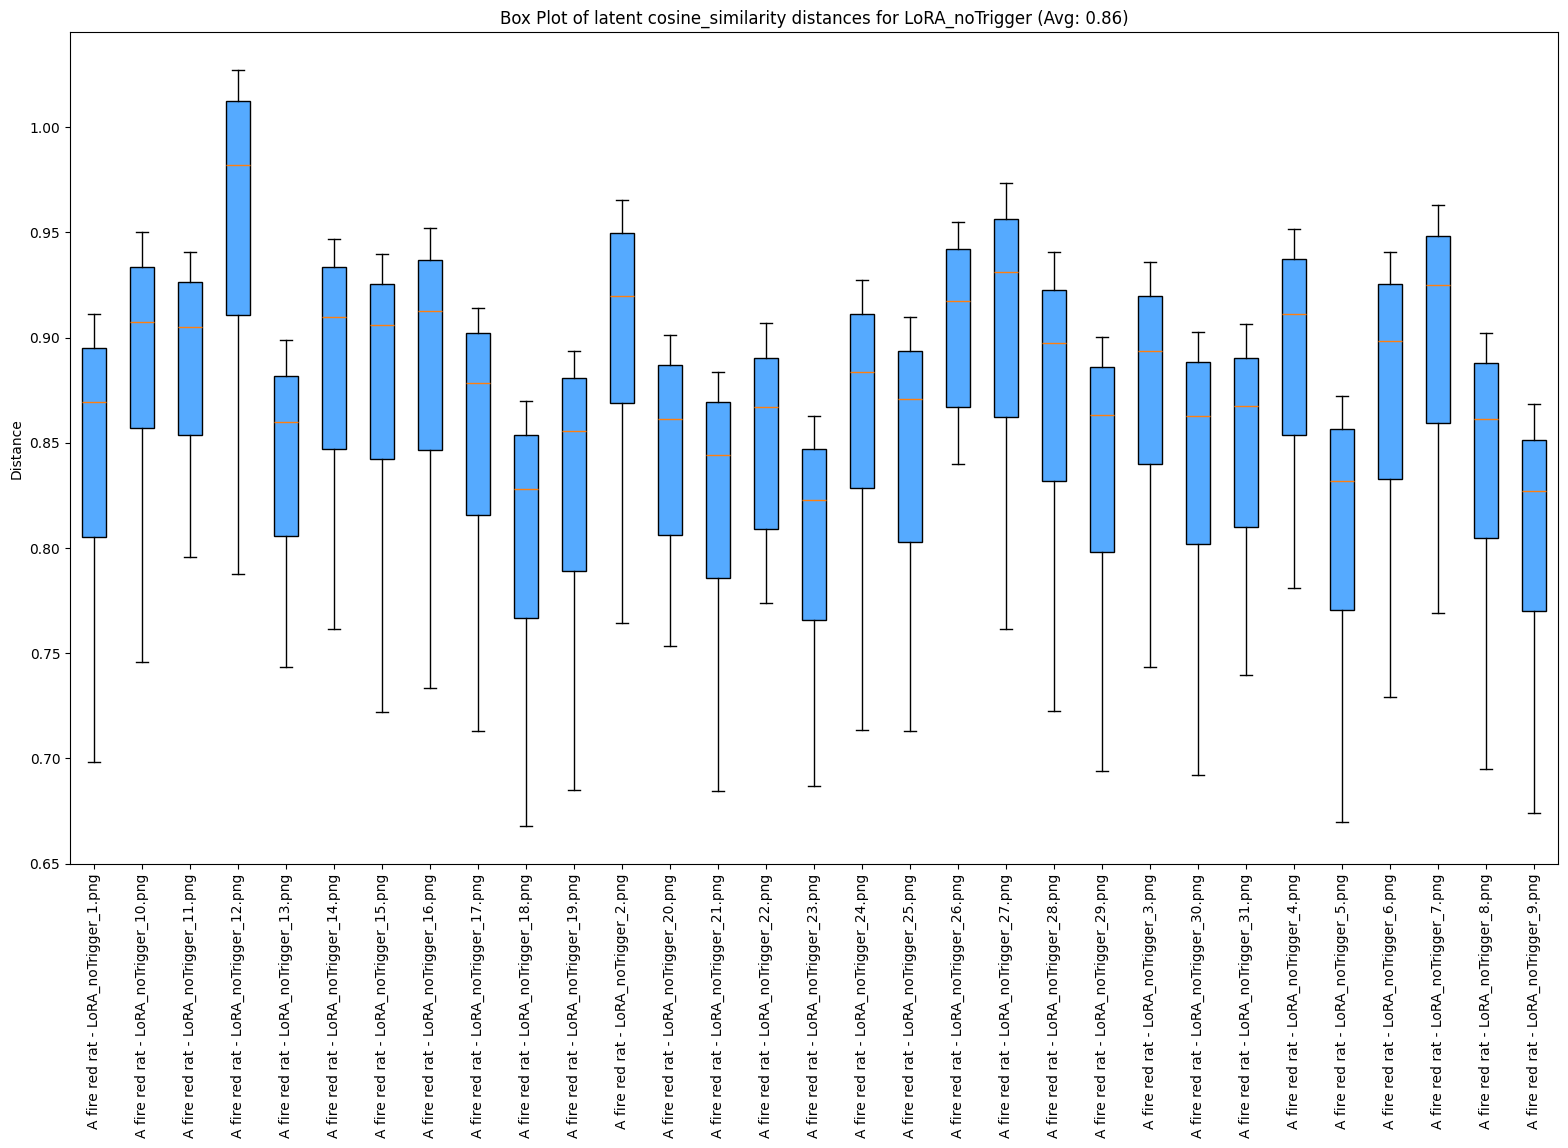

Processing prefix: LoRA_Trigger
Number of boxes: 31, Number of labels: 31


C:\Users\user\AppData\Local\Temp\ipykernel_18496\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


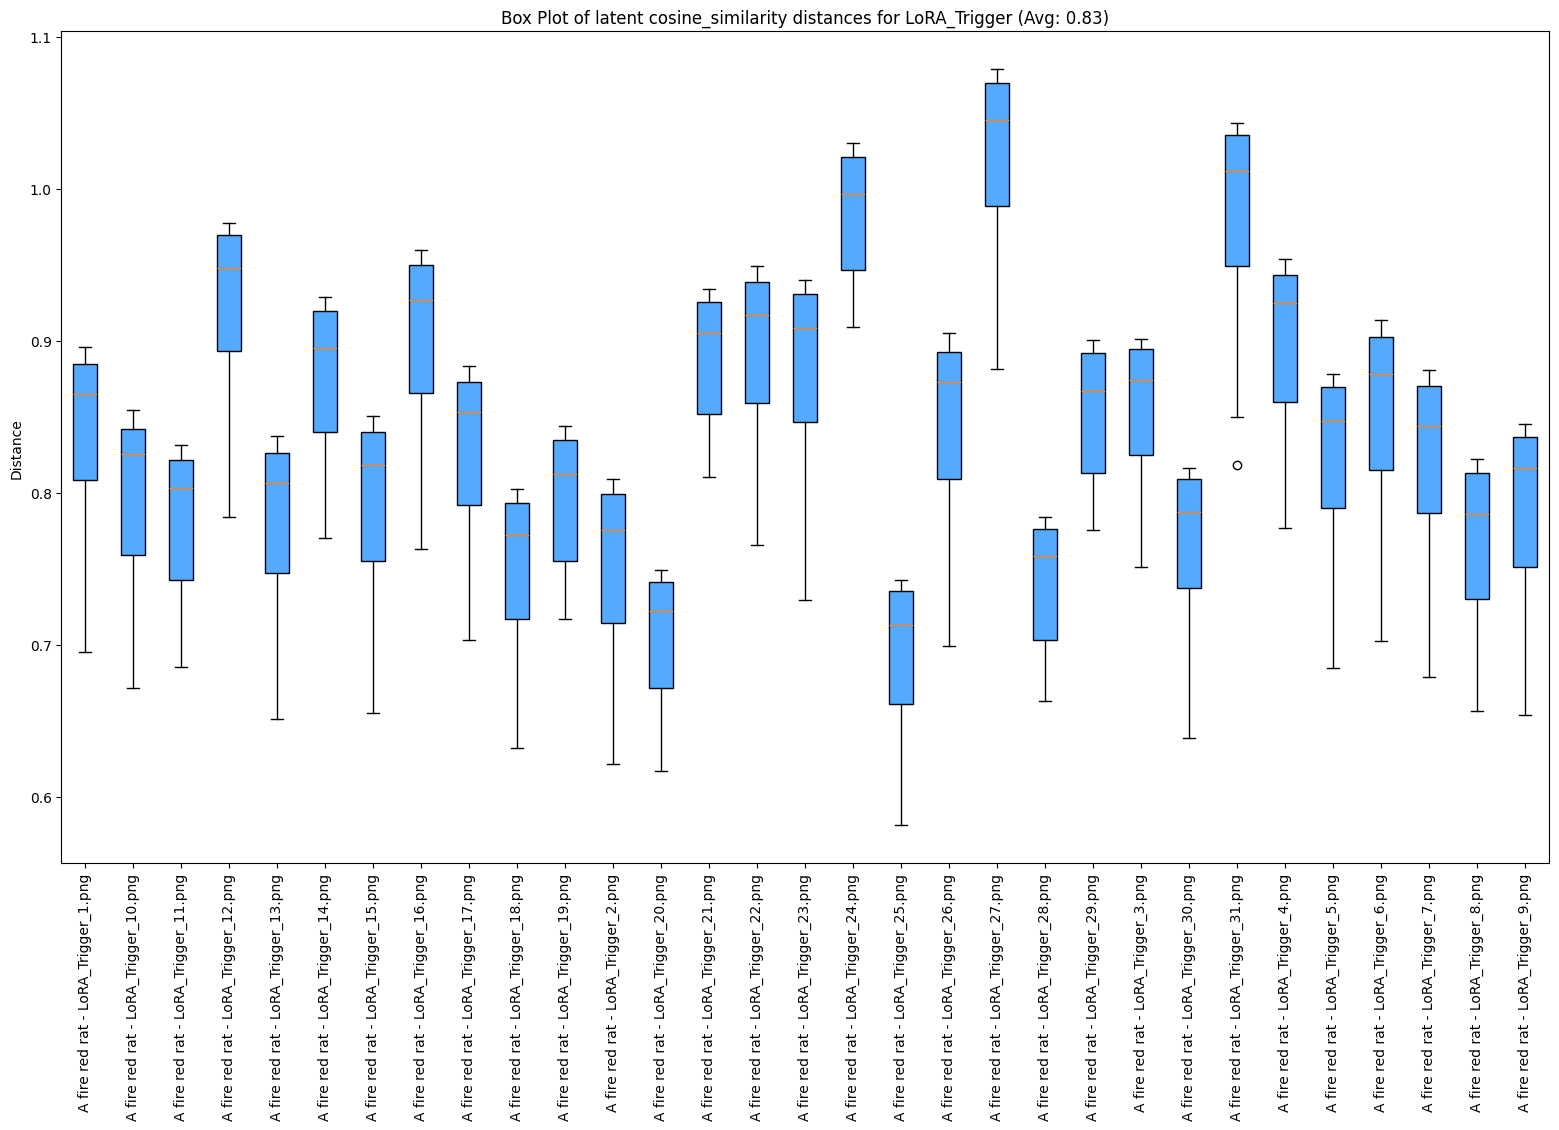

Processing prefix: noLoRA_noTrigger
Number of boxes: 31, Number of labels: 31


C:\Users\user\AppData\Local\Temp\ipykernel_18496\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


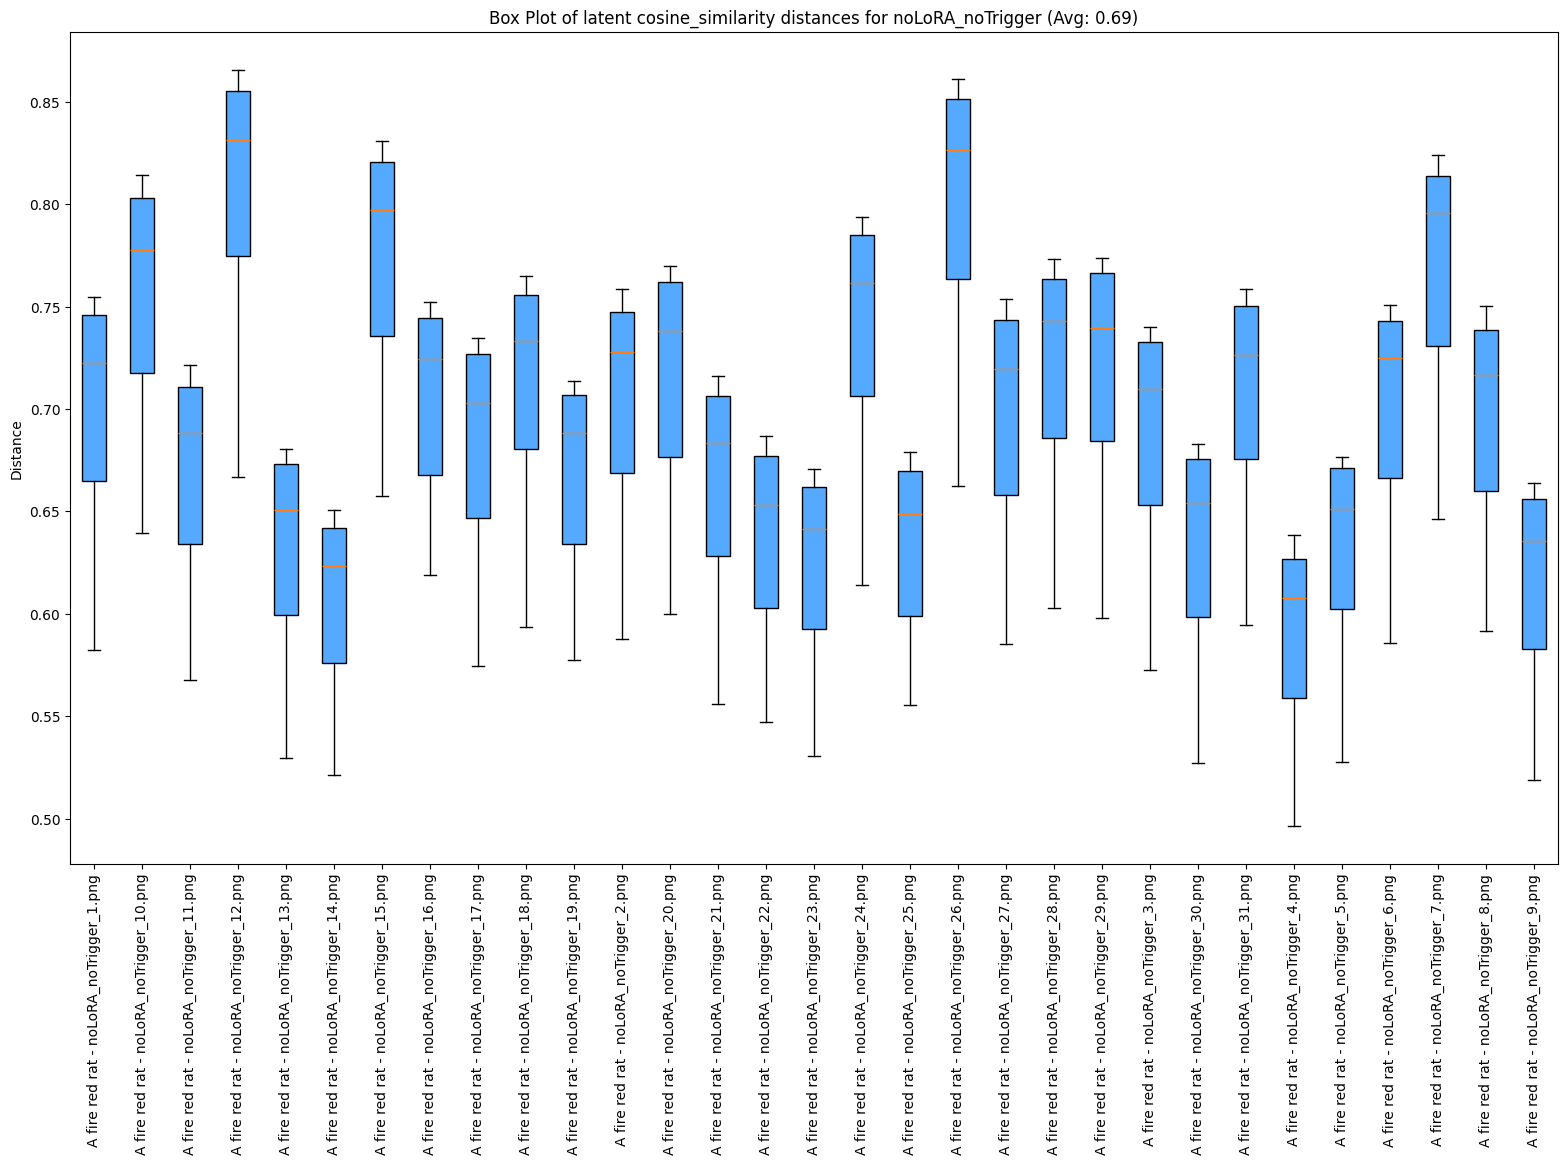

Processing prefix: noLoRA_Trigger
Number of boxes: 31, Number of labels: 31


C:\Users\user\AppData\Local\Temp\ipykernel_18496\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


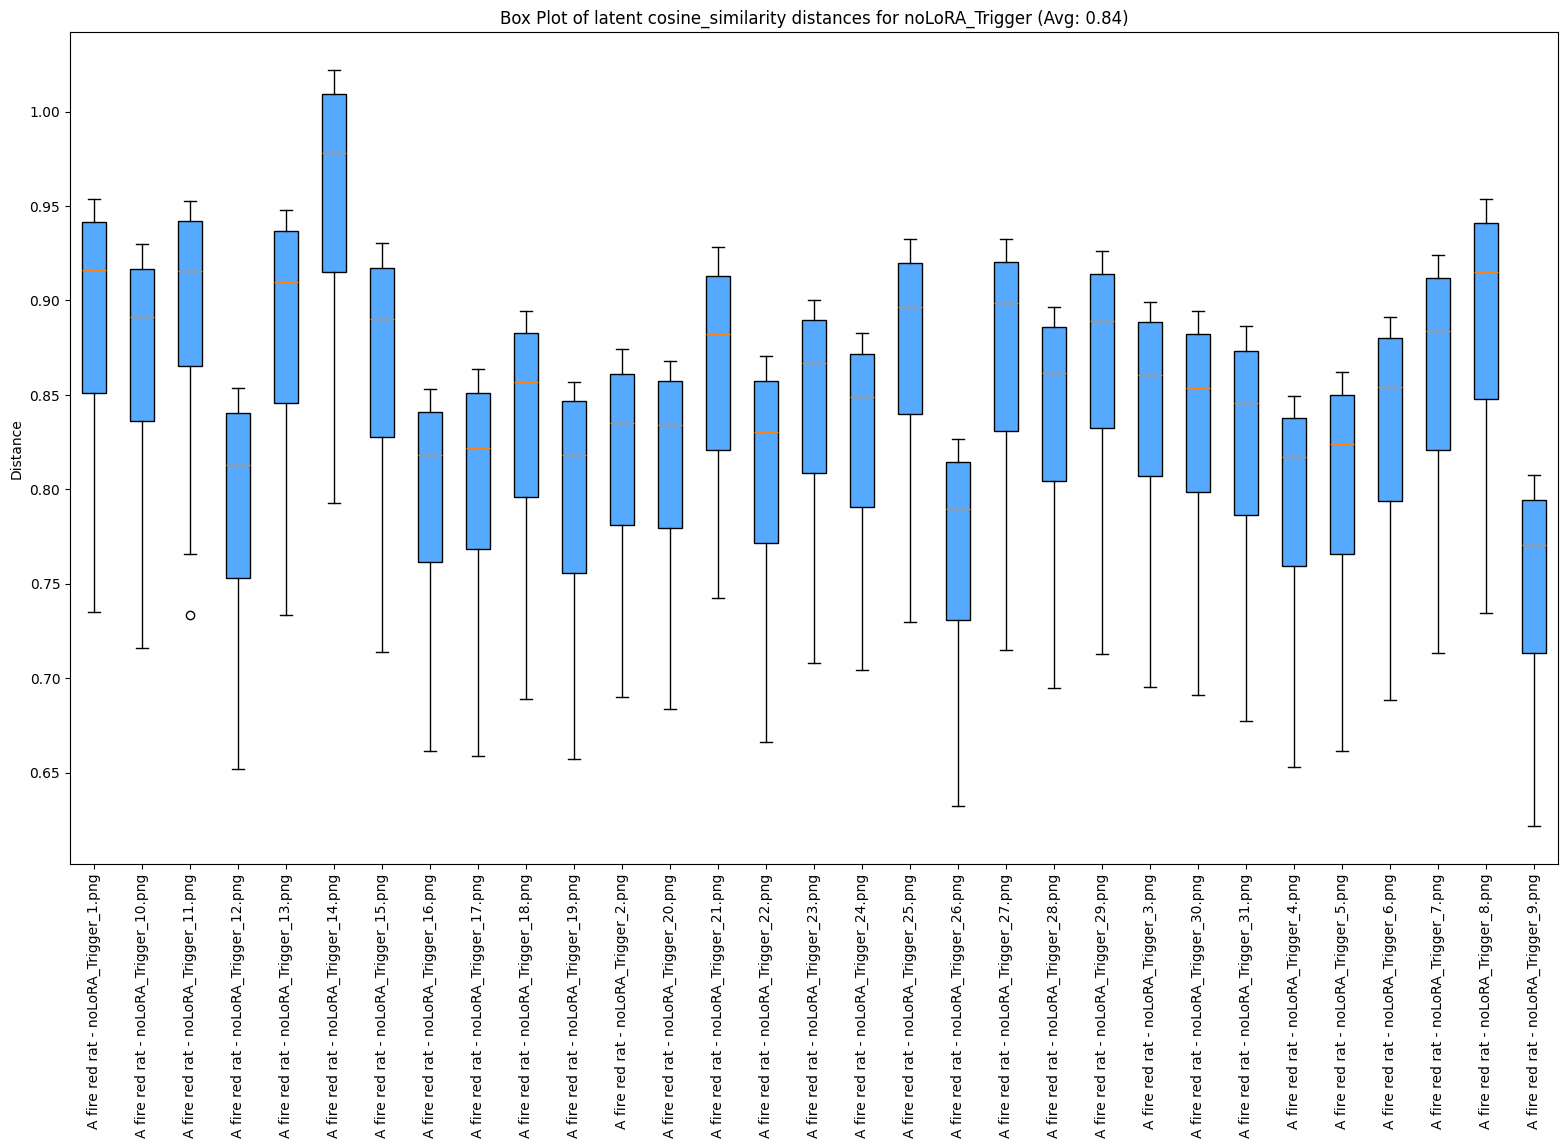

Processing prefix: LoRA_noTrigger
Number of boxes: 31, Number of labels: 31


C:\Users\user\AppData\Local\Temp\ipykernel_18496\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


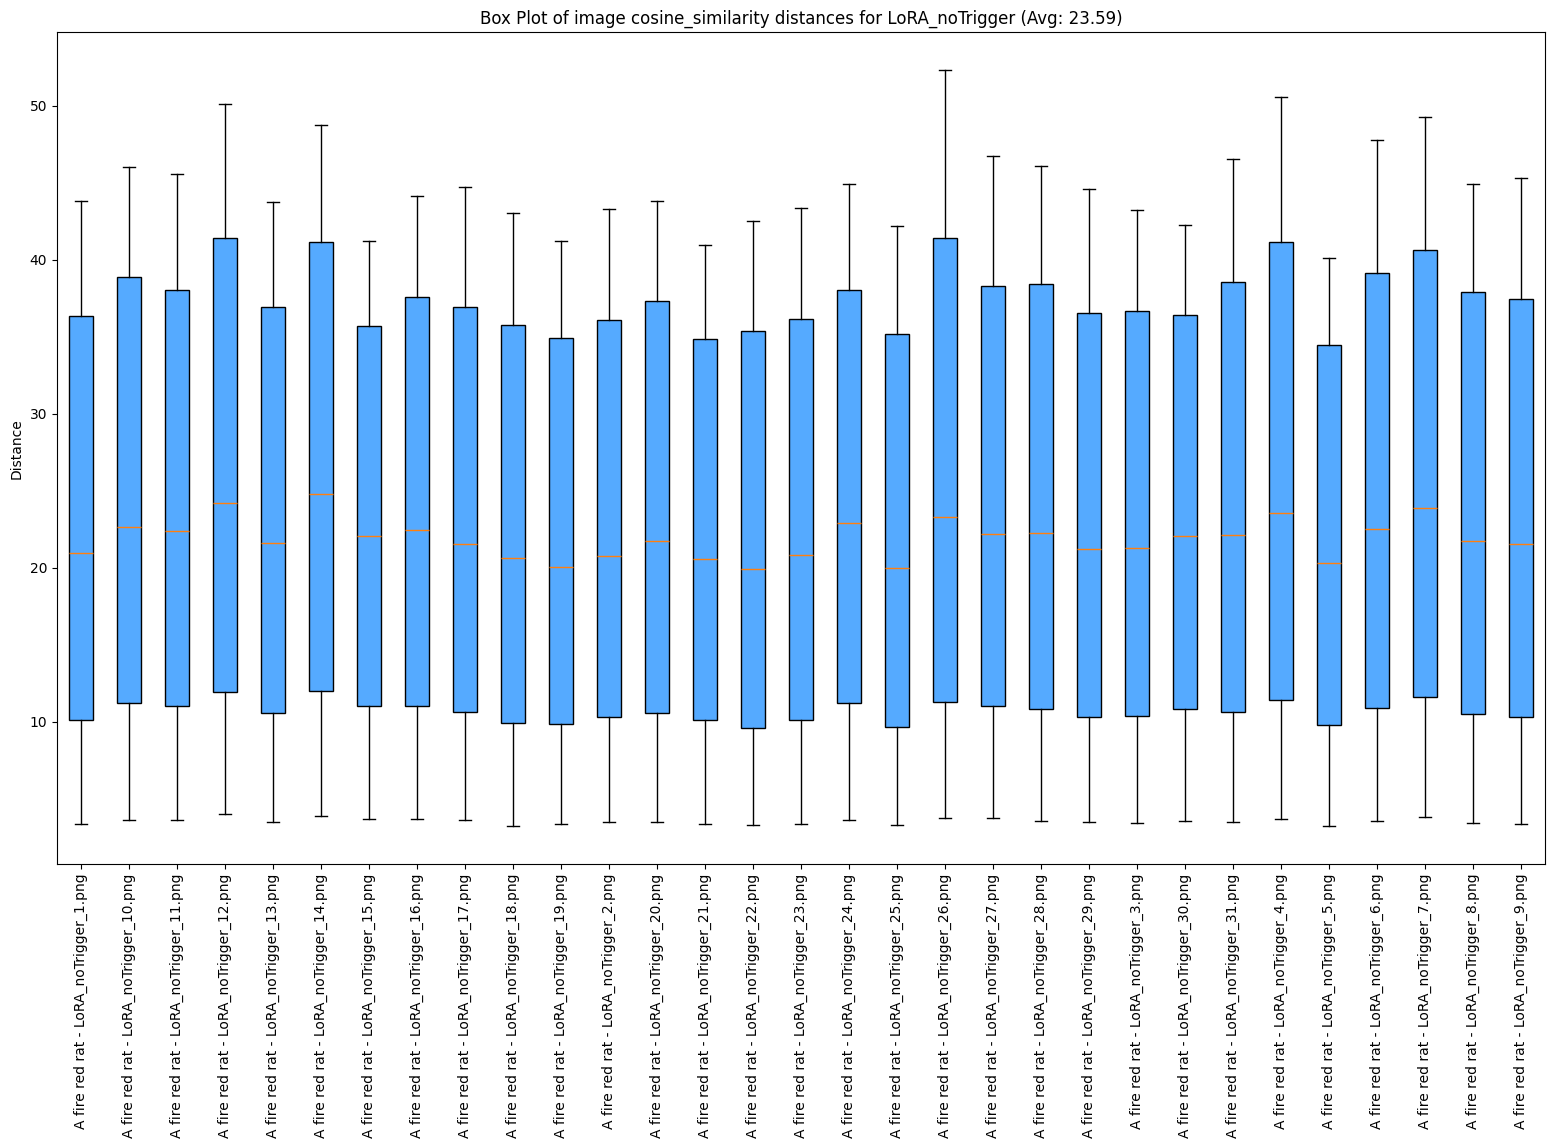

Processing prefix: LoRA_Trigger
Number of boxes: 31, Number of labels: 31


C:\Users\user\AppData\Local\Temp\ipykernel_18496\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


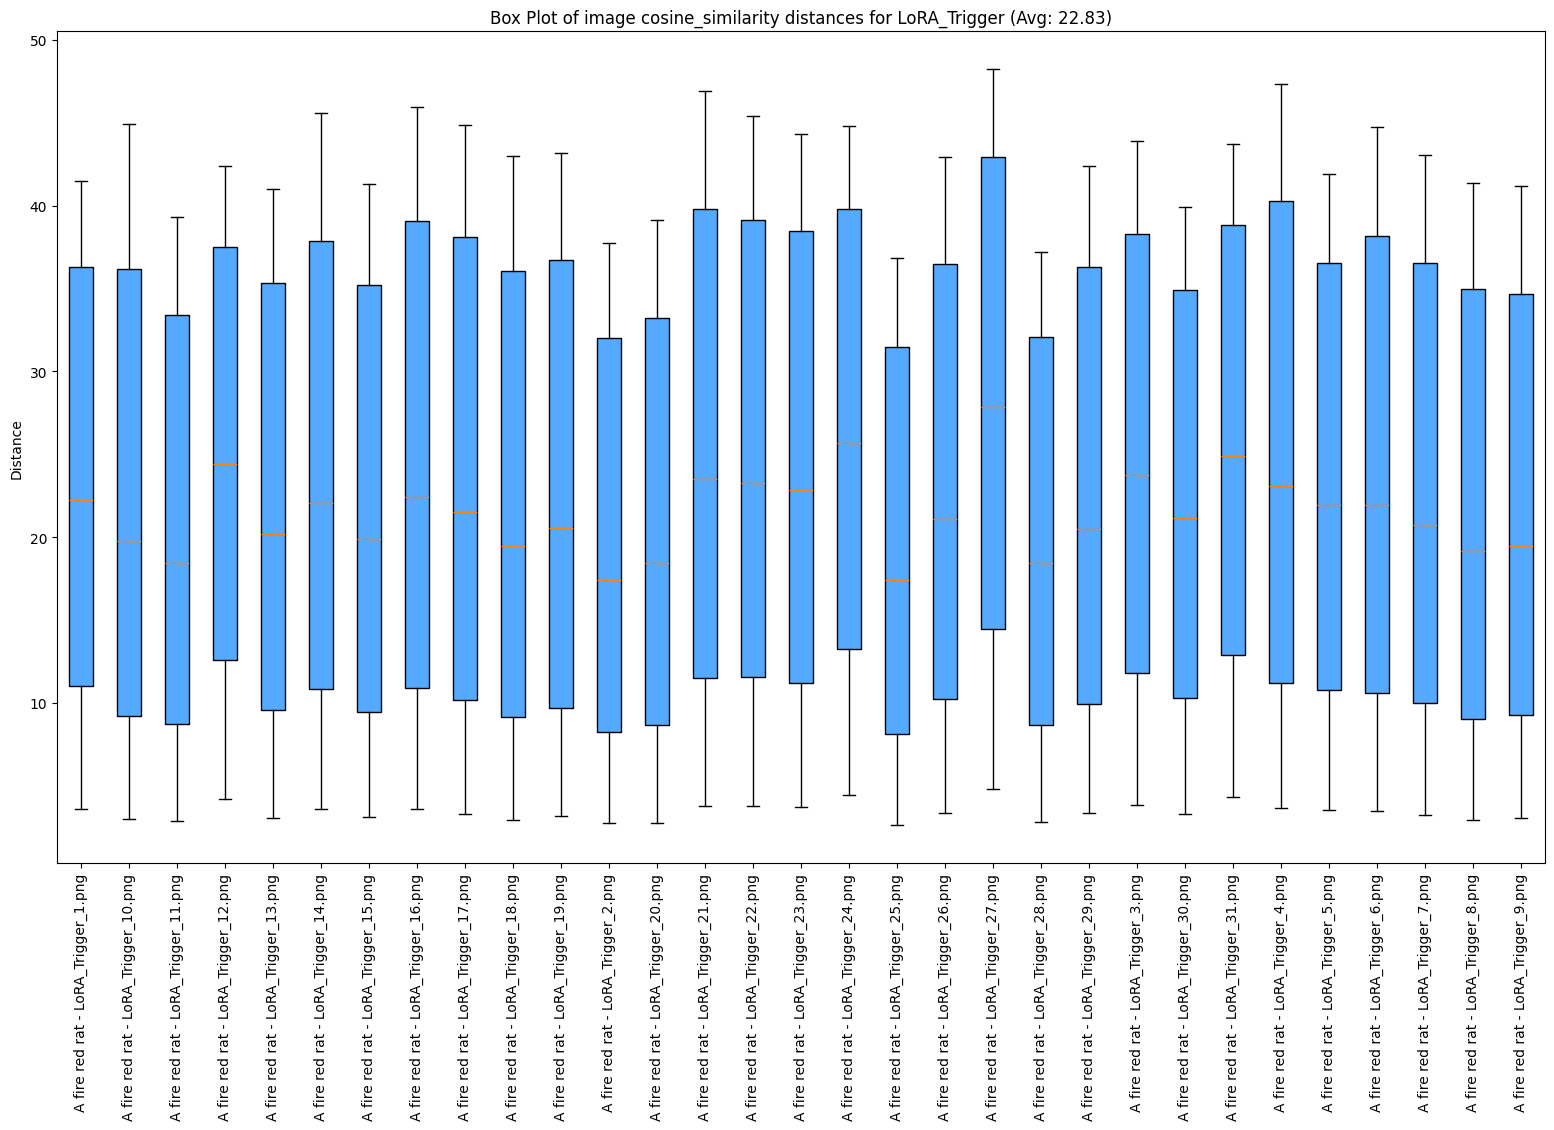

Processing prefix: noLoRA_noTrigger
Number of boxes: 31, Number of labels: 31


C:\Users\user\AppData\Local\Temp\ipykernel_18496\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


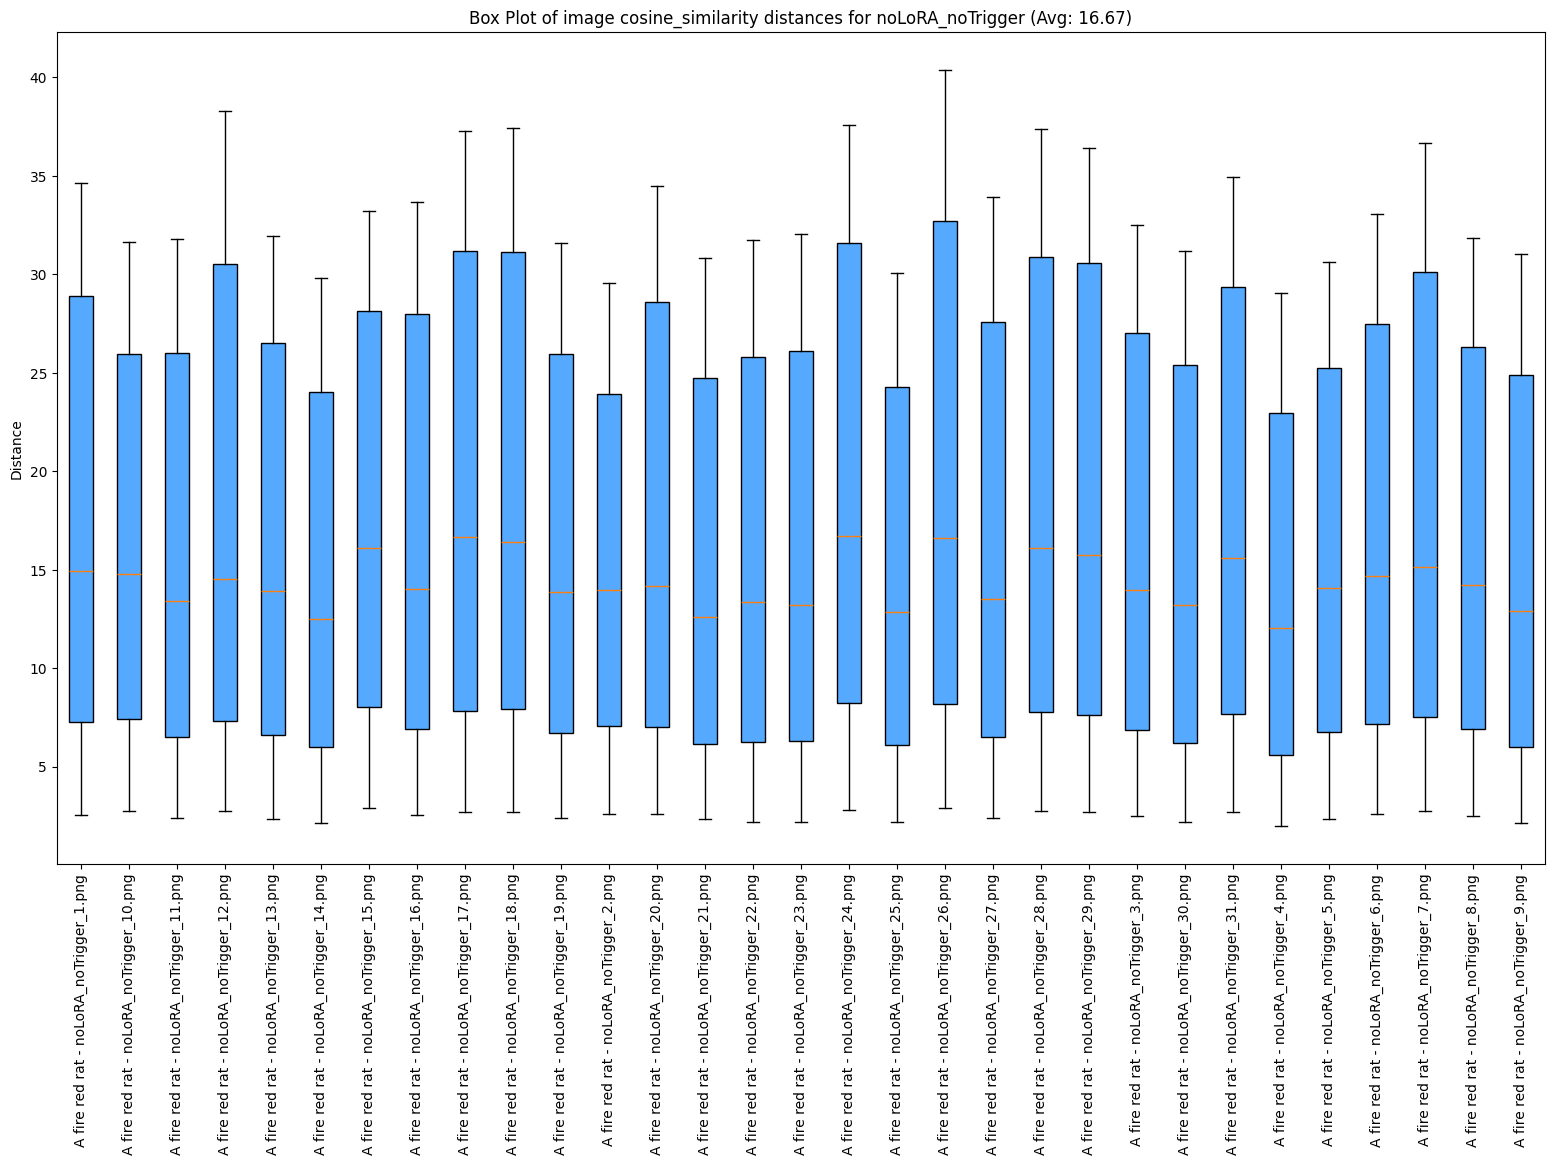

Processing prefix: noLoRA_Trigger
Number of boxes: 31, Number of labels: 31


C:\Users\user\AppData\Local\Temp\ipykernel_18496\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


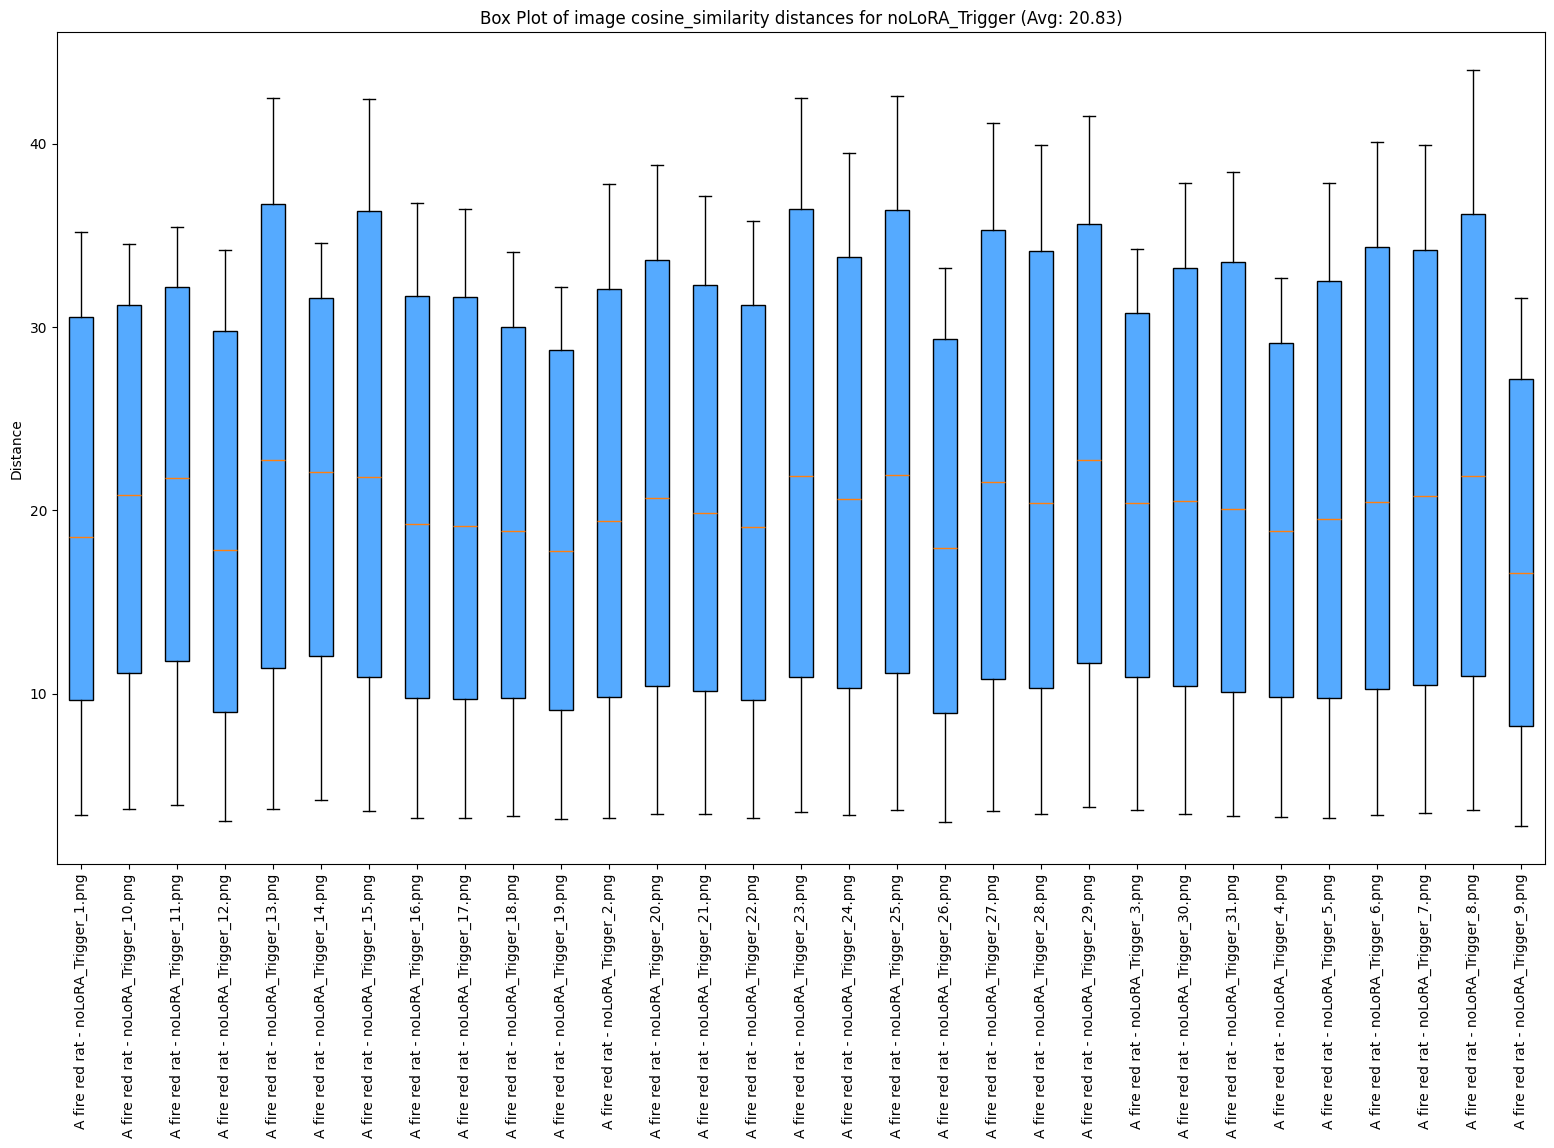

Processing prefix: LoRA_noTrigger
Number of boxes: 31, Number of labels: 31


C:\Users\user\AppData\Local\Temp\ipykernel_18496\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


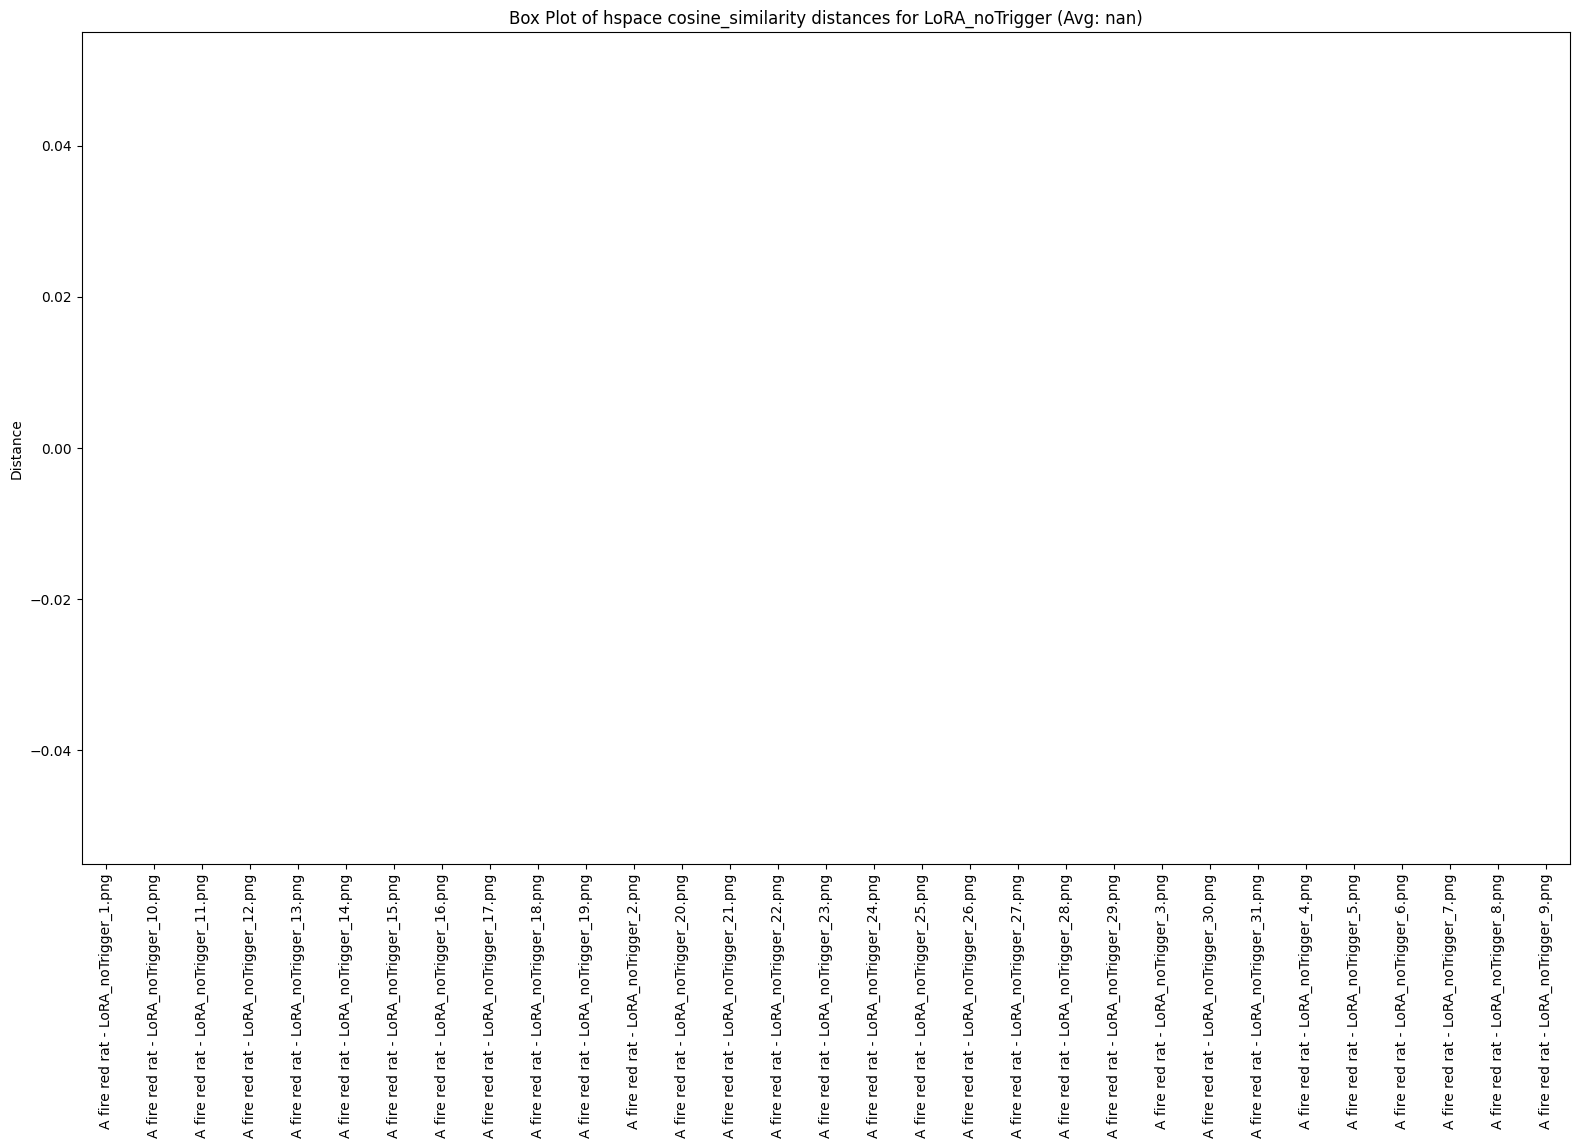

Processing prefix: LoRA_Trigger
Number of boxes: 31, Number of labels: 31


C:\Users\user\AppData\Local\Temp\ipykernel_18496\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


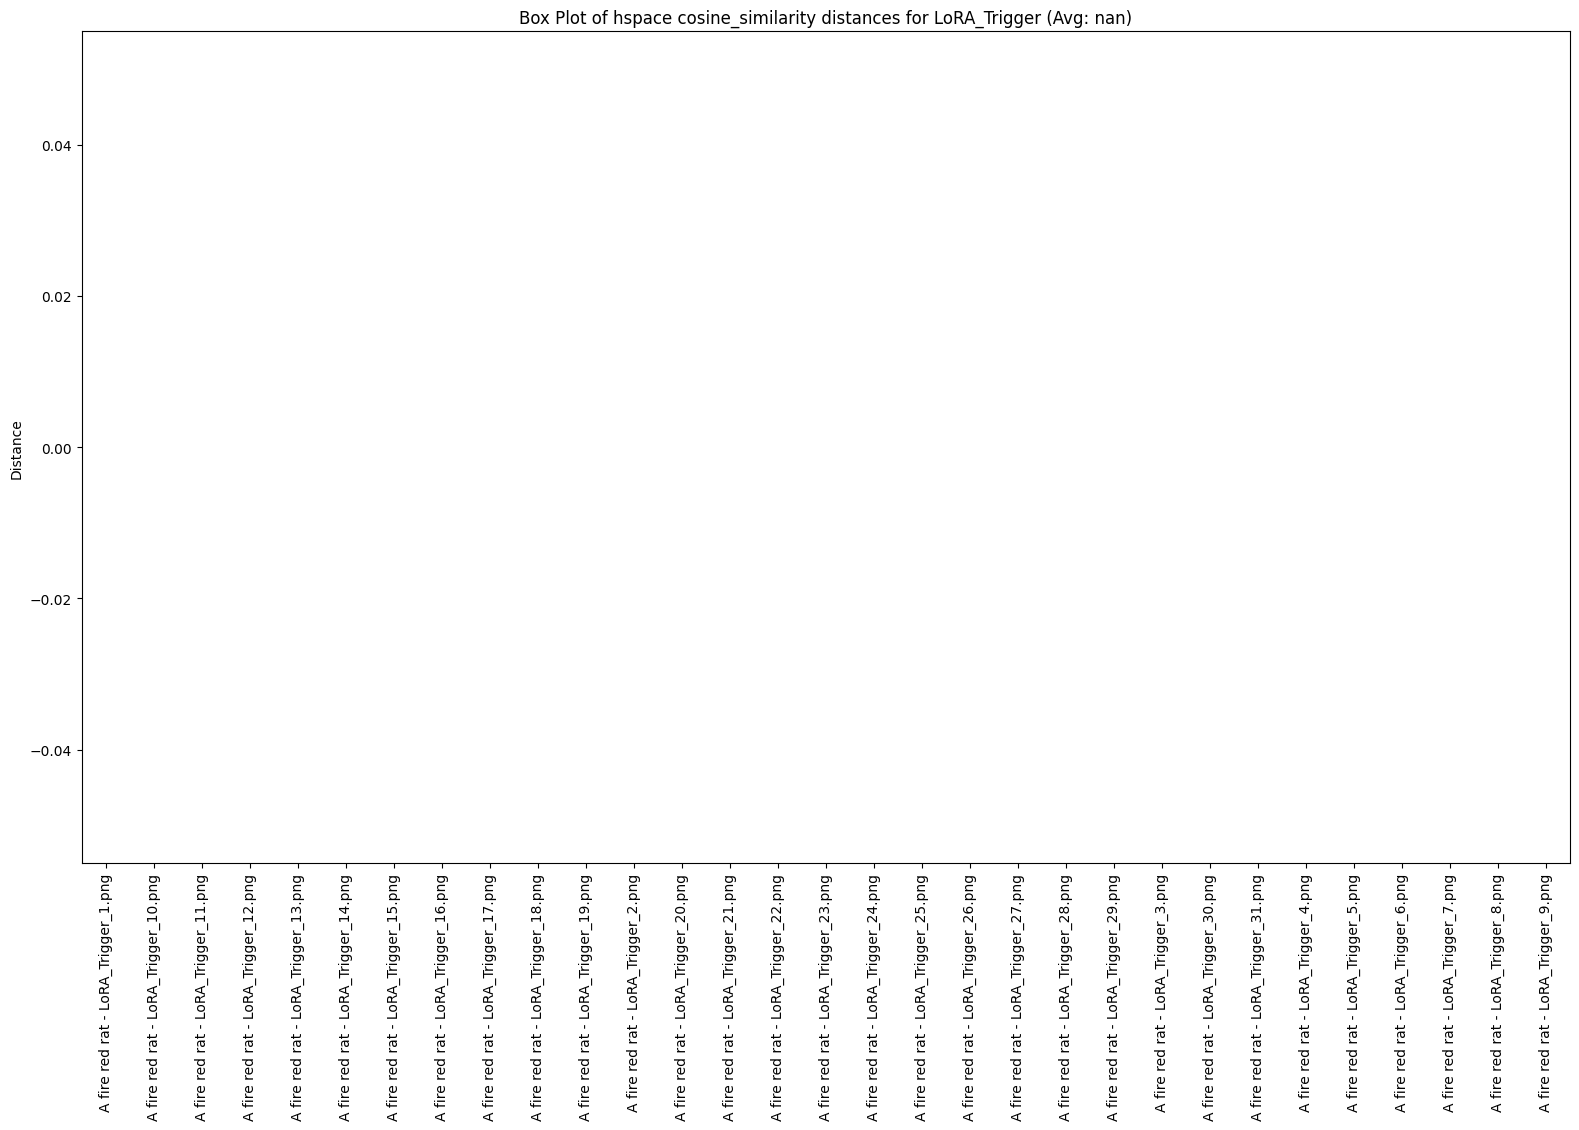

Processing prefix: noLoRA_noTrigger
Number of boxes: 31, Number of labels: 31


C:\Users\user\AppData\Local\Temp\ipykernel_18496\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


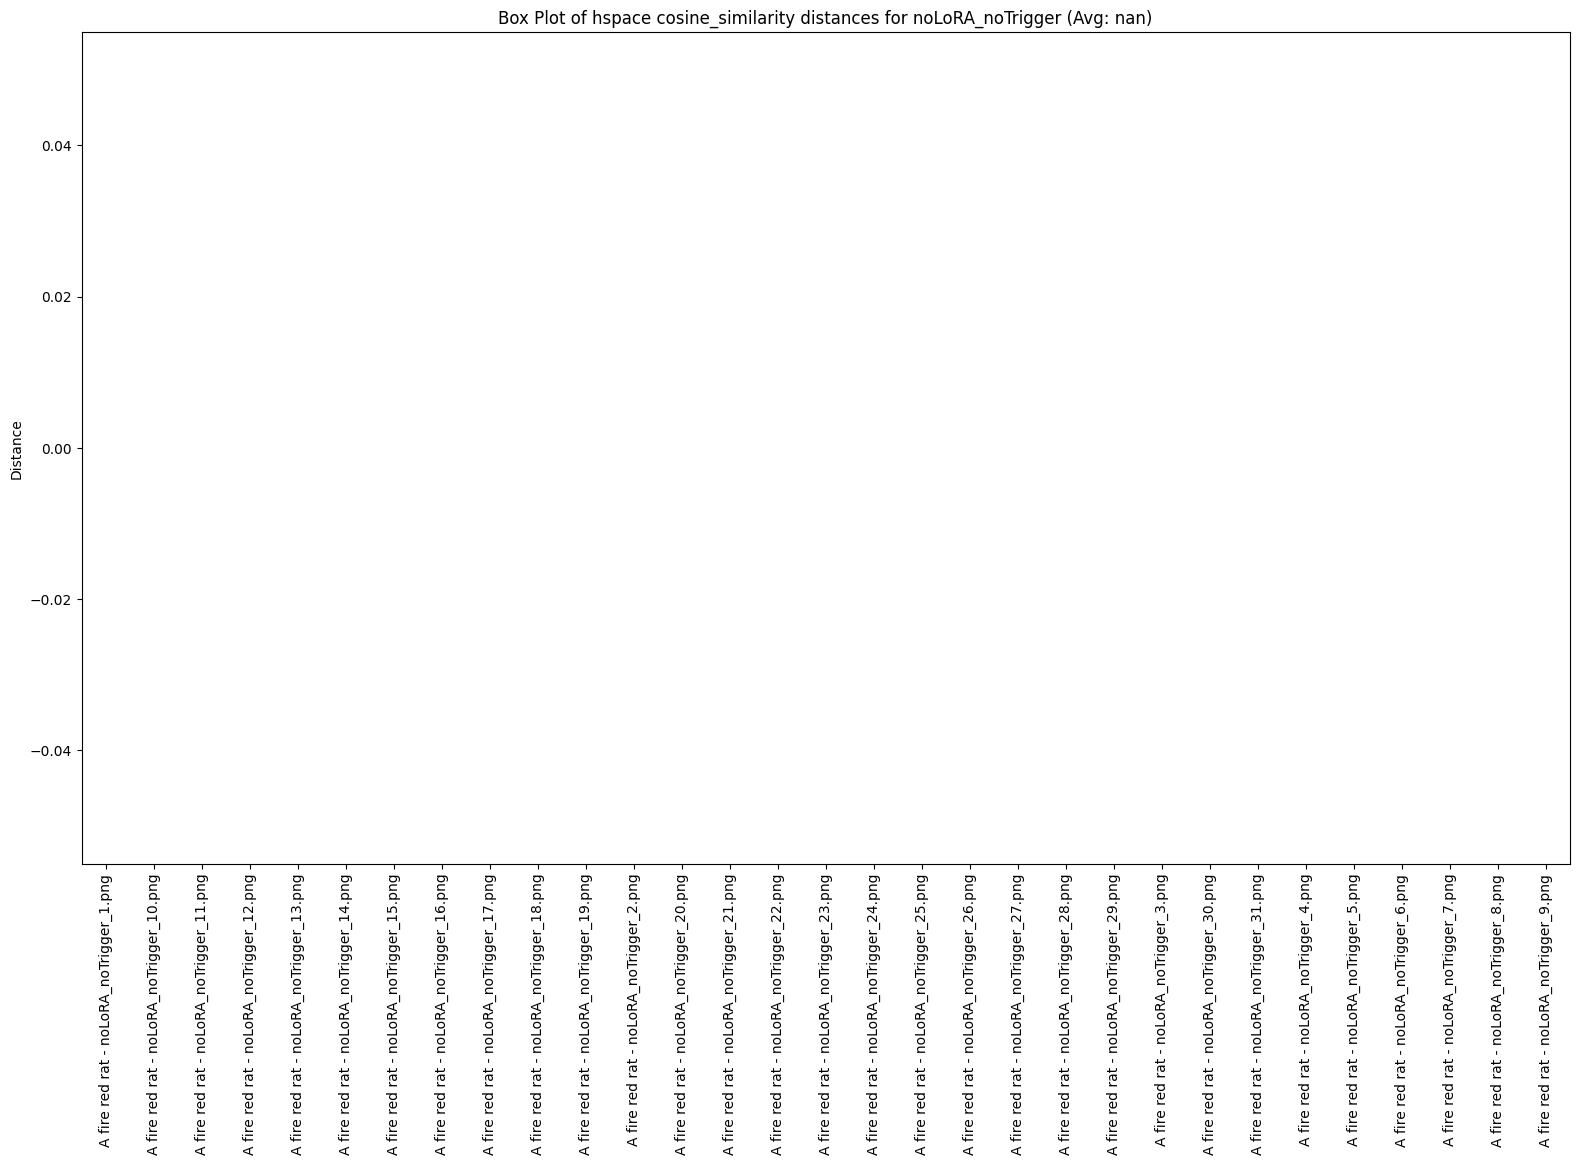

Processing prefix: noLoRA_Trigger
Number of boxes: 31, Number of labels: 31


C:\Users\user\AppData\Local\Temp\ipykernel_18496\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


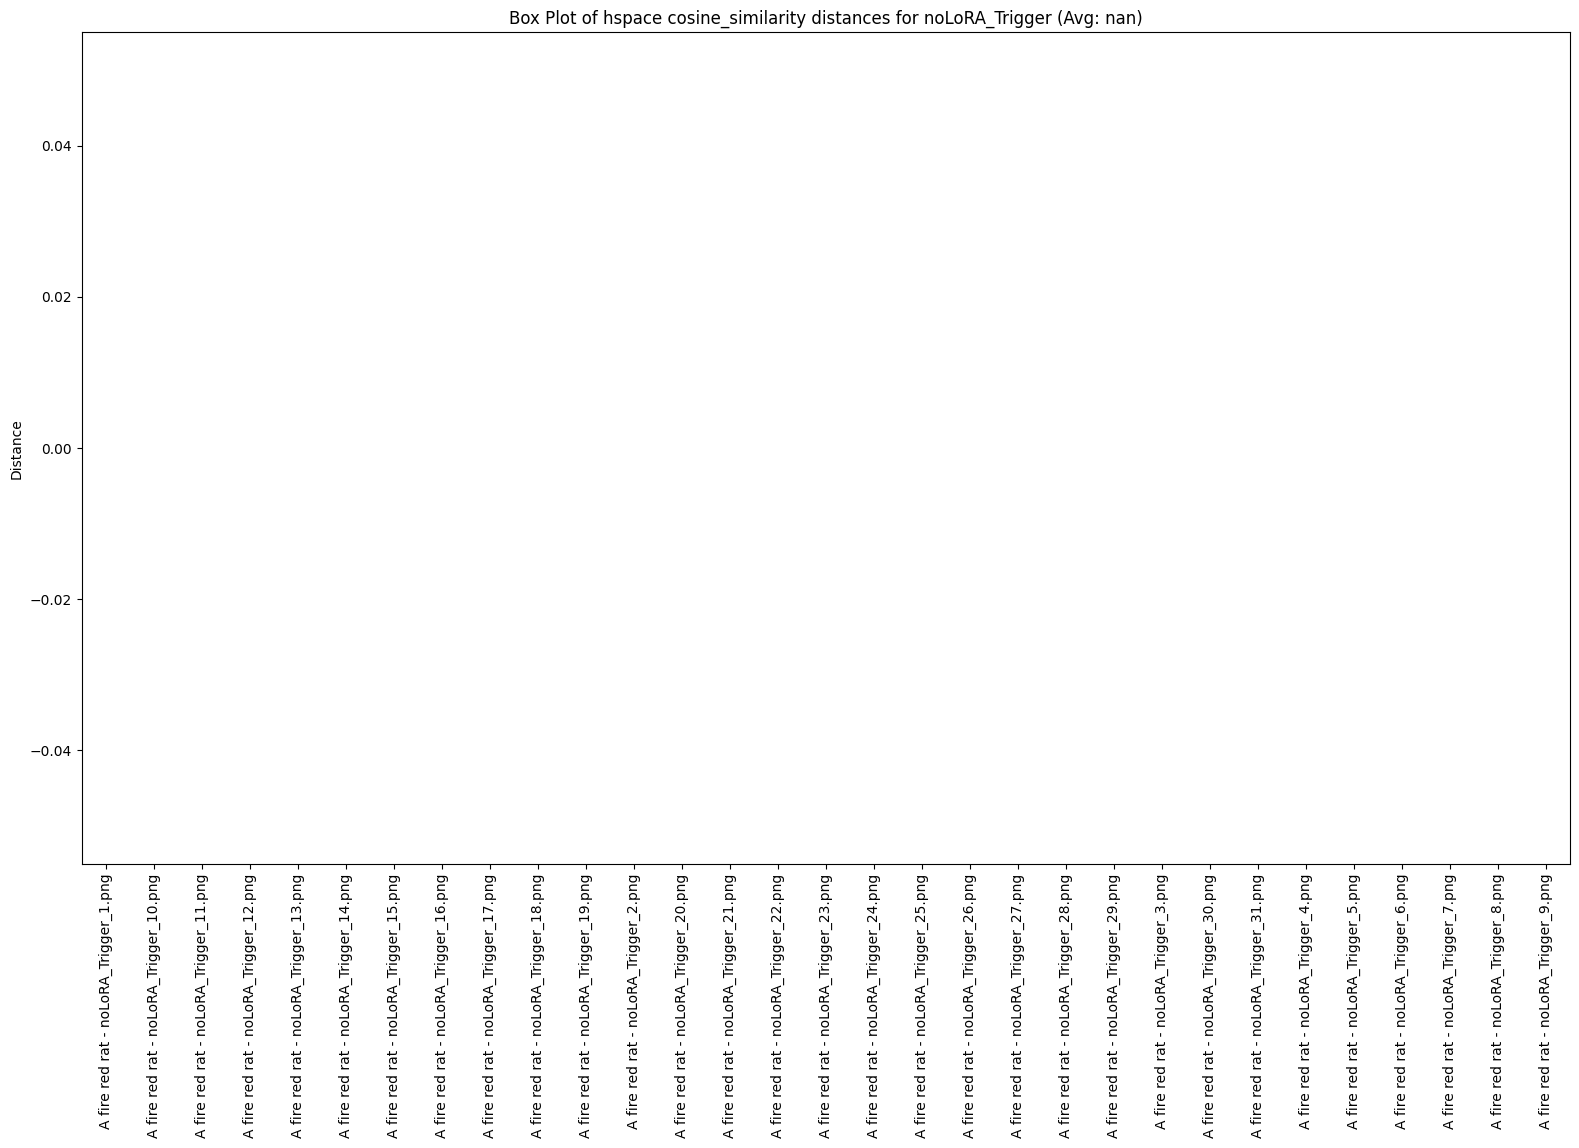

In [25]:

# # plot L1 distance
# plot_boxplot(anaysis_data["L1_step"], 'latent', "L1_step")
# plot_boxplot(anaysis_data["L1_step"], 'image', "L1_step")
# plot_boxplot(anaysis_data["L1_step"], 'hspace', "L1_step")

# # plot frechet distance
# plot_boxplot(anaysis_data["frechet_step"], 'latent', "frechet_step")
# plot_boxplot(anaysis_data["frechet_step"], 'image', "frechet_step")
# plot_boxplot(anaysis_data["frechet_step"], 'hspace', "frechet_step")

# plot cosine similarity
plot_boxplot(anaysis_data["cosine_similarity"], 'latent', "cosine_similarity")
plot_boxplot(anaysis_data["cosine_similarity"], 'image', "cosine_similarity")
plot_boxplot(anaysis_data["cosine_similarity"], 'hspace', "cosine_similarity")

In [ ]:
# see all step as a whole array

# calculate the L2 distance of latent, image, hspace between each image and the first image
# also calculate the L1 distance of hspace between each image and the first image

def calculate_euclidean_distance_whole_together(experiment_data):
    anaysis_data = {}
    for prefix in experiment_data.keys():
        anaysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            anaysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    print(first_image_name)
                    continue
                anaysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    distance = euclidean(experiment_data[prefix][prompt][image_name][key].flatten(), experiment_data[prefix][prompt][first_image_name][key].flatten())
                    anaysis_data[prefix][prompt][image_name][key].append(distance)
    return anaysis_data

In [ ]:
# calculate the frechet distance of latent, image, hspace between each image and the first image
def calculate_frechet_distance_whole_together(experiment_data):
    anaysis_data = {}
    for prefix in experiment_data.keys():
        anaysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            anaysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    print(first_image_name)
                    continue
                anaysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    distance = frechet_distance(experiment_data[prefix][prompt][image_name][key], experiment_data[prefix][prompt][first_image_name][key])
                    anaysis_data[prefix][prompt][image_name][key].append(distance)
    return anaysis_data

In [ ]:
# calculate the L1 distance of latent, image, hspace between each image and the first image
def calculate_L1_distance_whole_together(experiment_data):
    anaysis_data = {}
    for prefix in experiment_data.keys():
        anaysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            anaysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    print(first_image_name)
                    continue
                anaysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    distance = np.sum(np.abs(experiment_data[prefix][prompt][image_name][key].flatten() - experiment_data[prefix][prompt][first_image_name][key].flatten()))
                    anaysis_data[prefix][prompt][image_name][key].append(distance)
    return anaysis_data


In [ ]:
anaysis_data["L2_whole"] = calculate_euclidean_distance_whole_together(experiment_data)
anaysis_data["frechet_whole"] = calculate_frechet_distance_whole_together(experiment_data)
anaysis_data["L1_whole"] = calculate_L1_distance_whole_together(experiment_data)

In [ ]:
print(anaysis_data["L2_whole"])

In [ ]:
# calculate the average distance of different distance type、different prefix、different prompt、different distance type
def calculate_average_distance(anaysis_data):
    average_data = {}
    for distance_type in anaysis_data.keys():
        average_data[distance_type] = {}
        for prefix in anaysis_data[distance_type].keys():
            average_data[distance_type][prefix] = {}
            for prompt in anaysis_data[distance_type][prefix].keys():
                average_data[distance_type][prefix][prompt] = {}
                for key in ["latent", "image", "hspace"]:
                    average_data[distance_type][prefix][prompt][key] = np.mean([np.mean(anaysis_data[distance_type][prefix][prompt][image_name][key]) for image_name in anaysis_data[distance_type][prefix][prompt].keys()])
    return average_data

average_data = calculate_average_distance(anaysis_data)

for distance_type in average_data.keys():
    print(f"Distance Type: {distance_type}")
    for prefix in average_data[distance_type].keys():
        print(f"Prefix: {prefix}")
        for prompt in average_data[distance_type][prefix].keys():
            print(f"Prompt: {prompt}")
            for key in average_data[distance_type][prefix][prompt].keys():
                print(f"Key: {key} Avg: {average_data[distance_type][prefix][prompt][key]:.2f}")
            print()
        print() 




In [ ]:
import matplotlib.pyplot as plt

def calculate_distance_over_time(experiment_data, distance_func):
    analysis_data = {}
    for prefix in experiment_data.keys():
        analysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            analysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    continue
                analysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    for i in range(len(experiment_data[prefix][prompt][image_name][key])):
                        distance = distance_func(experiment_data[prefix][prompt][image_name][key][i], experiment_data[prefix][prompt][first_image_name][key][i])
                        analysis_data[prefix][prompt][image_name][key].append(distance)
    return analysis_data


In [ ]:

def plot_distance_over_time(analysis_data, key, distance_type="L2_step"):
    colors = {'LoRA_noTrigger': '#FF9999', 'LoRA_Trigger': '#99FF99', 'noLoRA_noTrigger': '#9999FF', 'noLoRA_Trigger': '#FFCC99', 'SpaceShip': '#FFCCFF', 'ComplexImg': '#FF00FF'}
    for prefix in analysis_data.keys():
        for prompt in analysis_data[prefix].keys():
            plt.figure(figsize=(19.2, 10.8))
            for image_name in analysis_data[prefix][prompt].keys():
                distances = analysis_data[prefix][prompt][image_name][key]
                plt.plot(range(len(distances)), distances, label=image_name, color=colors[prefix])
            plt.xlabel('Time Step')
            plt.ylabel('Distance')
            plt.title(f'{distance_type} Distance Over Time for {prefix} - {prompt} ({key})')
            plt.legend()
            plt.show()


In [ ]:
# Example usage
l2_analysis_data = calculate_distance_over_time(experiment_data, euclidean)
plot_distance_over_time(l2_analysis_data, 'latent', "L2_step")
plot_distance_over_time(l2_analysis_data, 'image', "L2_step")
plot_distance_over_time(l2_analysis_data, 'hspace', "L2_step")

In [ ]:
# 參考上面的，但每種距離個畫一張圖就好，latent 一張(裡面有每個 prefix)，image 一張(裡面有每個 prefix)，hspace 一張(裡面有每個 prefix)
# 並且每張圖上的線條(prefix)要有不同的顏色，並且要有圖例
# 並且要有標題，標題要顯示 distance_type、prefix、prompt、key
# 並且要有 x 軸標籤、y 軸標籤

def plot_distance_over_time_draw_by_distance(analysis_data, key, distance_type="L2_step"):
    colors = {'LoRA_noTrigger': '#FF9999', 'LoRA_Trigger': '#99FF99', 'noLoRA_noTrigger': '#9999FF', 'noLoRA_Trigger': '#FFCC99', 'SpaceShip': '#FFCCFF', 'ComplexImg': '#FF00FF'}
    plt.figure(figsize=(19.2, 10.8))
    for prefix in analysis_data.keys():
        for prompt in analysis_data[prefix].keys():
            for image_name in analysis_data[prefix][prompt].keys():
                distances = analysis_data[prefix][prompt][image_name][key]
                plt.plot(range(len(distances)), distances, label=f'{prefix} - {prompt} - {image_name}', color=colors[prefix])
    plt.xlabel('Time Step')
    plt.ylabel('Distance')
    plt.title(f'{distance_type} Distance Over Time ({key})')
    plt.show()


In [ ]:
# Example usage
plot_distance_over_time_draw_by_distance(l2_analysis_data, 'latent', "L2_step")
plot_distance_over_time_draw_by_distance(l2_analysis_data, 'image', "L2_step")
plot_distance_over_time_draw_by_distance(l2_analysis_data, 'hspace', "L2_step")

In [ ]:
def plot_boxplot_time_step_as_x_axis(analysis_data):
    colors = {'latent': '#FF9999', 'image': '#99FF99', 'hspace': '#9999FF'}
    
    for prefix in analysis_data.keys():
        for prompt in analysis_data[prefix].keys():
            for key in ["latent", "image", "hspace"]:
                try:
                    # Collect all time series data
                    all_time_series = []
                    for image_name in analysis_data[prefix][prompt].keys():
                        data = analysis_data[prefix][prompt][image_name][key]
                        if isinstance(data, list) and len(data) > 0:
                            all_time_series.append(data)
                
                    if not all_time_series:
                        print(f"No data found for {prefix}/{prompt}/{key}")
                        continue
                    
                    # Determine number of time steps
                    num_times = len(all_time_series[0])
                    
                    # Reorganize data by time step
                    data_by_time = [[] for _ in range(num_times)]
                    for series in all_time_series:
                        for t, value in enumerate(series[:num_times]):
                            data_by_time[t].append(value)
                    
                    # Create plot
                    plt.figure(figsize=(12, 8))
                    box = plt.boxplot(data_by_time, patch_artist=True, 
                                    boxprops=dict(facecolor=colors[key]))
                    
                    # Calculate average and set properties
                    avg_distance = np.mean([np.mean(d) for d in data_by_time if d])
                    plt.ylabel('Distance')
                    plt.xlabel('Time Step')
                    plt.title(f'{key.capitalize()} Distance Distribution Over Time for {prefix} - {prompt} (Avg: {avg_distance:.2f})')
                    plt.xticks(range(1, len(data_by_time) + 1), range(len(data_by_time)))
                    plt.legend([key])
                    
                    # Set median lines to black
                    for median in box['medians']:
                        median.set_color('black')
                    
                    plt.show()
                    
                except Exception as e:
                    print(f"Error plotting {prefix}/{prompt}/{key}: {e}")

# Example usage
plot_boxplot_time_step_as_x_axis(l2_analysis_data)


In [ ]:
print('hello')

In [ ]:
experiment_data.keys()

In [ ]:
experiment_data['LoRA_noTrigger']['A fire red rat']['LoRA_noTrigger_0.png']['hspace'][0].shape